# Introduction

The Philippine Statistics Authority (PSA) spearheads the conduct of the Family Income and Expenditure Survey (FIES) nationwide. The survey, which is undertaken every three (3) years, is aimed at providing data on family income and expenditure, including, among others, levels of consumption by item of expenditure, sources of income in cash, and related information affecting income and expenditure levels and patterns in the Philippines.

1. First we will use methods of EDA to explore and clean the data into a format which we can use for further investigation.
2. We will then look for correlations between the target variable (Total Household Income) and the feature variables.
3. Once we go through our feature selection phase, from which we will build examples of the machine learning models we've previously explored.
4. Finally we will compare the results of each model and provide a summary of which model best summarizes and correlates feature variables to target  variable.

The data comes from [this kaggle dataset]('https://www.kaggle.com/grosvenpaul/family-income-and-expenditure') and all metrics are in PHP (Philippine Peso)

In [42]:
# Set Up Environment
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, boxcox
from scipy.stats.mstats import winsorize
import seaborn as sns

# Packages for supervised learning
from sklearn import preprocessing, tree, metrics, ensemble, svm, datasets
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from statsmodels.tools.eval_measures import mse, rmse
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
#from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz
import time
import xgboost as xgb

# Exploratory Data Analysis (EDA)

## Handling Missing/Null values

First, let's load the data into data frame using Pandas and explore what the data looks like

In [2]:
# Load data into dataframe
df = pd.read_csv('D:\\Thinkful Data Science\\Data Sets\\family-income-and-expenditure\\Family Income and Expenditure.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41544 entries, 0 to 41543
Data columns (total 60 columns):
Total Household Income                           41544 non-null int64
Region                                           41544 non-null object
Total Food Expenditure                           41544 non-null int64
Main Source of Income                            41544 non-null object
Agricultural Household indicator                 41544 non-null int64
Bread and Cereals Expenditure                    41544 non-null int64
Total Rice Expenditure                           41544 non-null int64
Meat Expenditure                                 41544 non-null int64
Total Fish and  marine products Expenditure      41544 non-null int64
Fruit Expenditure                                41544 non-null int64
Vegetables Expenditure                           41544 non-null int64
Restaurant and hotels Expenditure                41544 non-null int64
Alcoholic Beverages Expenditure                  

In [3]:
# Look at the first rows to see what the data looks like
df.head()

,Total Household Income,Region,Total Food Expenditure,Main Source of Income,Agricultural Household indicator,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,...,Number of Refrigerator/Freezer,Number of Washing Machine,Number of Airconditioner,"Number of Car, Jeep, Van",Number of Landline/wireless telephones,Number of Cellular phone,Number of Personal Computer,Number of Stove with Oven/Gas Range,Number of Motorized Banca,Number of Motorcycle/Tricycle
0,480332,CAR,117848,Wage/Salaries,0,42140,38300,24676,16806,3325,...,1,1,0,0,0,2,1,0,0,1
1,198235,CAR,67766,Wage/Salaries,0,17329,13008,17434,11073,2035,...,0,1,0,0,0,3,1,0,0,2
2,82785,CAR,61609,Wage/Salaries,1,34182,32001,7783,2590,1730,...,0,0,0,0,0,0,0,0,0,0
3,107589,CAR,78189,Wage/Salaries,0,34030,28659,10914,10812,690,...,0,0,0,0,0,1,0,0,0,0
4,189322,CAR,94625,Wage/Salaries,0,34820,30167,18391,11309,1395,...,1,0,0,0,0,3,0,0,0,1


In [4]:
# Counting null values
null_count = df.isnull().sum()
null_count[null_count>0]

Household Head Occupation         7536
Household Head Class of Worker    7536
dtype: int64

In [5]:
# Since the number of missing values is low, drop values from dataframe
df = df.dropna()

In [6]:
# Determine how many unique entries for each categorical column
categorical = df.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print('\n', i, column.nunique())
    #print(column.nunique())
    print(df[i].value_counts())


 Region 17
IVA - CALABARZON             3238
NCR                          3109
III - Central Luzon          2433
VI - Western Visayas         2303
 ARMM                        2094
VII - Central Visayas        2092
XI - Davao Region            2080
V - Bicol Region             2061
VIII - Eastern Visayas       1967
II - Cagayan Valley          1854
XII - SOCCSKSARGEN           1808
I - Ilocos Region            1795
X - Northern Mindanao        1598
IX - Zasmboanga Peninsula    1541
Caraga                       1504
CAR                          1428
IVB - MIMAROPA               1103
Name: Region, dtype: int64

 Main Source of Income 3
Wage/Salaries                 17749
Enterpreneurial Activities     9660
Other sources of Income        6599
Name: Main Source of Income, dtype: int64

 Household Head Sex 2
Male      28646
Female     5362
Name: Household Head Sex, dtype: int64

 Household Head Marital Status 6
Married               27493
Widowed                3794
Single                 

From the summary of categorical columns above, we will remove a few entries that don't make sense or add much value to our analysis.

1. Household Head Marital Status - remove unknown (qty 1)
2. Drop columns that have too many categorical entries

In [7]:
df.drop(df[df['Household Head Marital Status'] == 'Unknown'].index, inplace=True)
df.drop('Household Head Occupation', axis=1, inplace=True)

Now we have removed null values as well as values that don't make sense.

## Outliers

In [8]:
# Let's first create a list of columns that have numerical values
numerical_columns = df.select_dtypes(['int64']).columns
print (numerical_columns, len(numerical_columns))

Index(['Total Household Income', 'Total Food Expenditure',
       'Agricultural Household indicator', 'Bread and Cereals Expenditure',
       'Total Rice Expenditure', 'Meat Expenditure',
       'Total Fish and  marine products Expenditure', 'Fruit Expenditure',
       'Vegetables Expenditure', 'Restaurant and hotels Expenditure',
       'Alcoholic Beverages Expenditure', 'Tobacco Expenditure',
       'Clothing, Footwear and Other Wear Expenditure',
       'Housing and water Expenditure', 'Imputed House Rental Value',
       'Medical Care Expenditure', 'Transportation Expenditure',
       'Communication Expenditure', 'Education Expenditure',
       'Miscellaneous Goods and Services Expenditure',
       'Special Occasions Expenditure', 'Crop Farming and Gardening expenses',
       'Total Income from Entrepreneurial Acitivites', 'Household Head Age',
       'Total Number of Family members',
       'Members with age less than 5 year old',
       'Members with age 5 - 17 years old',
      

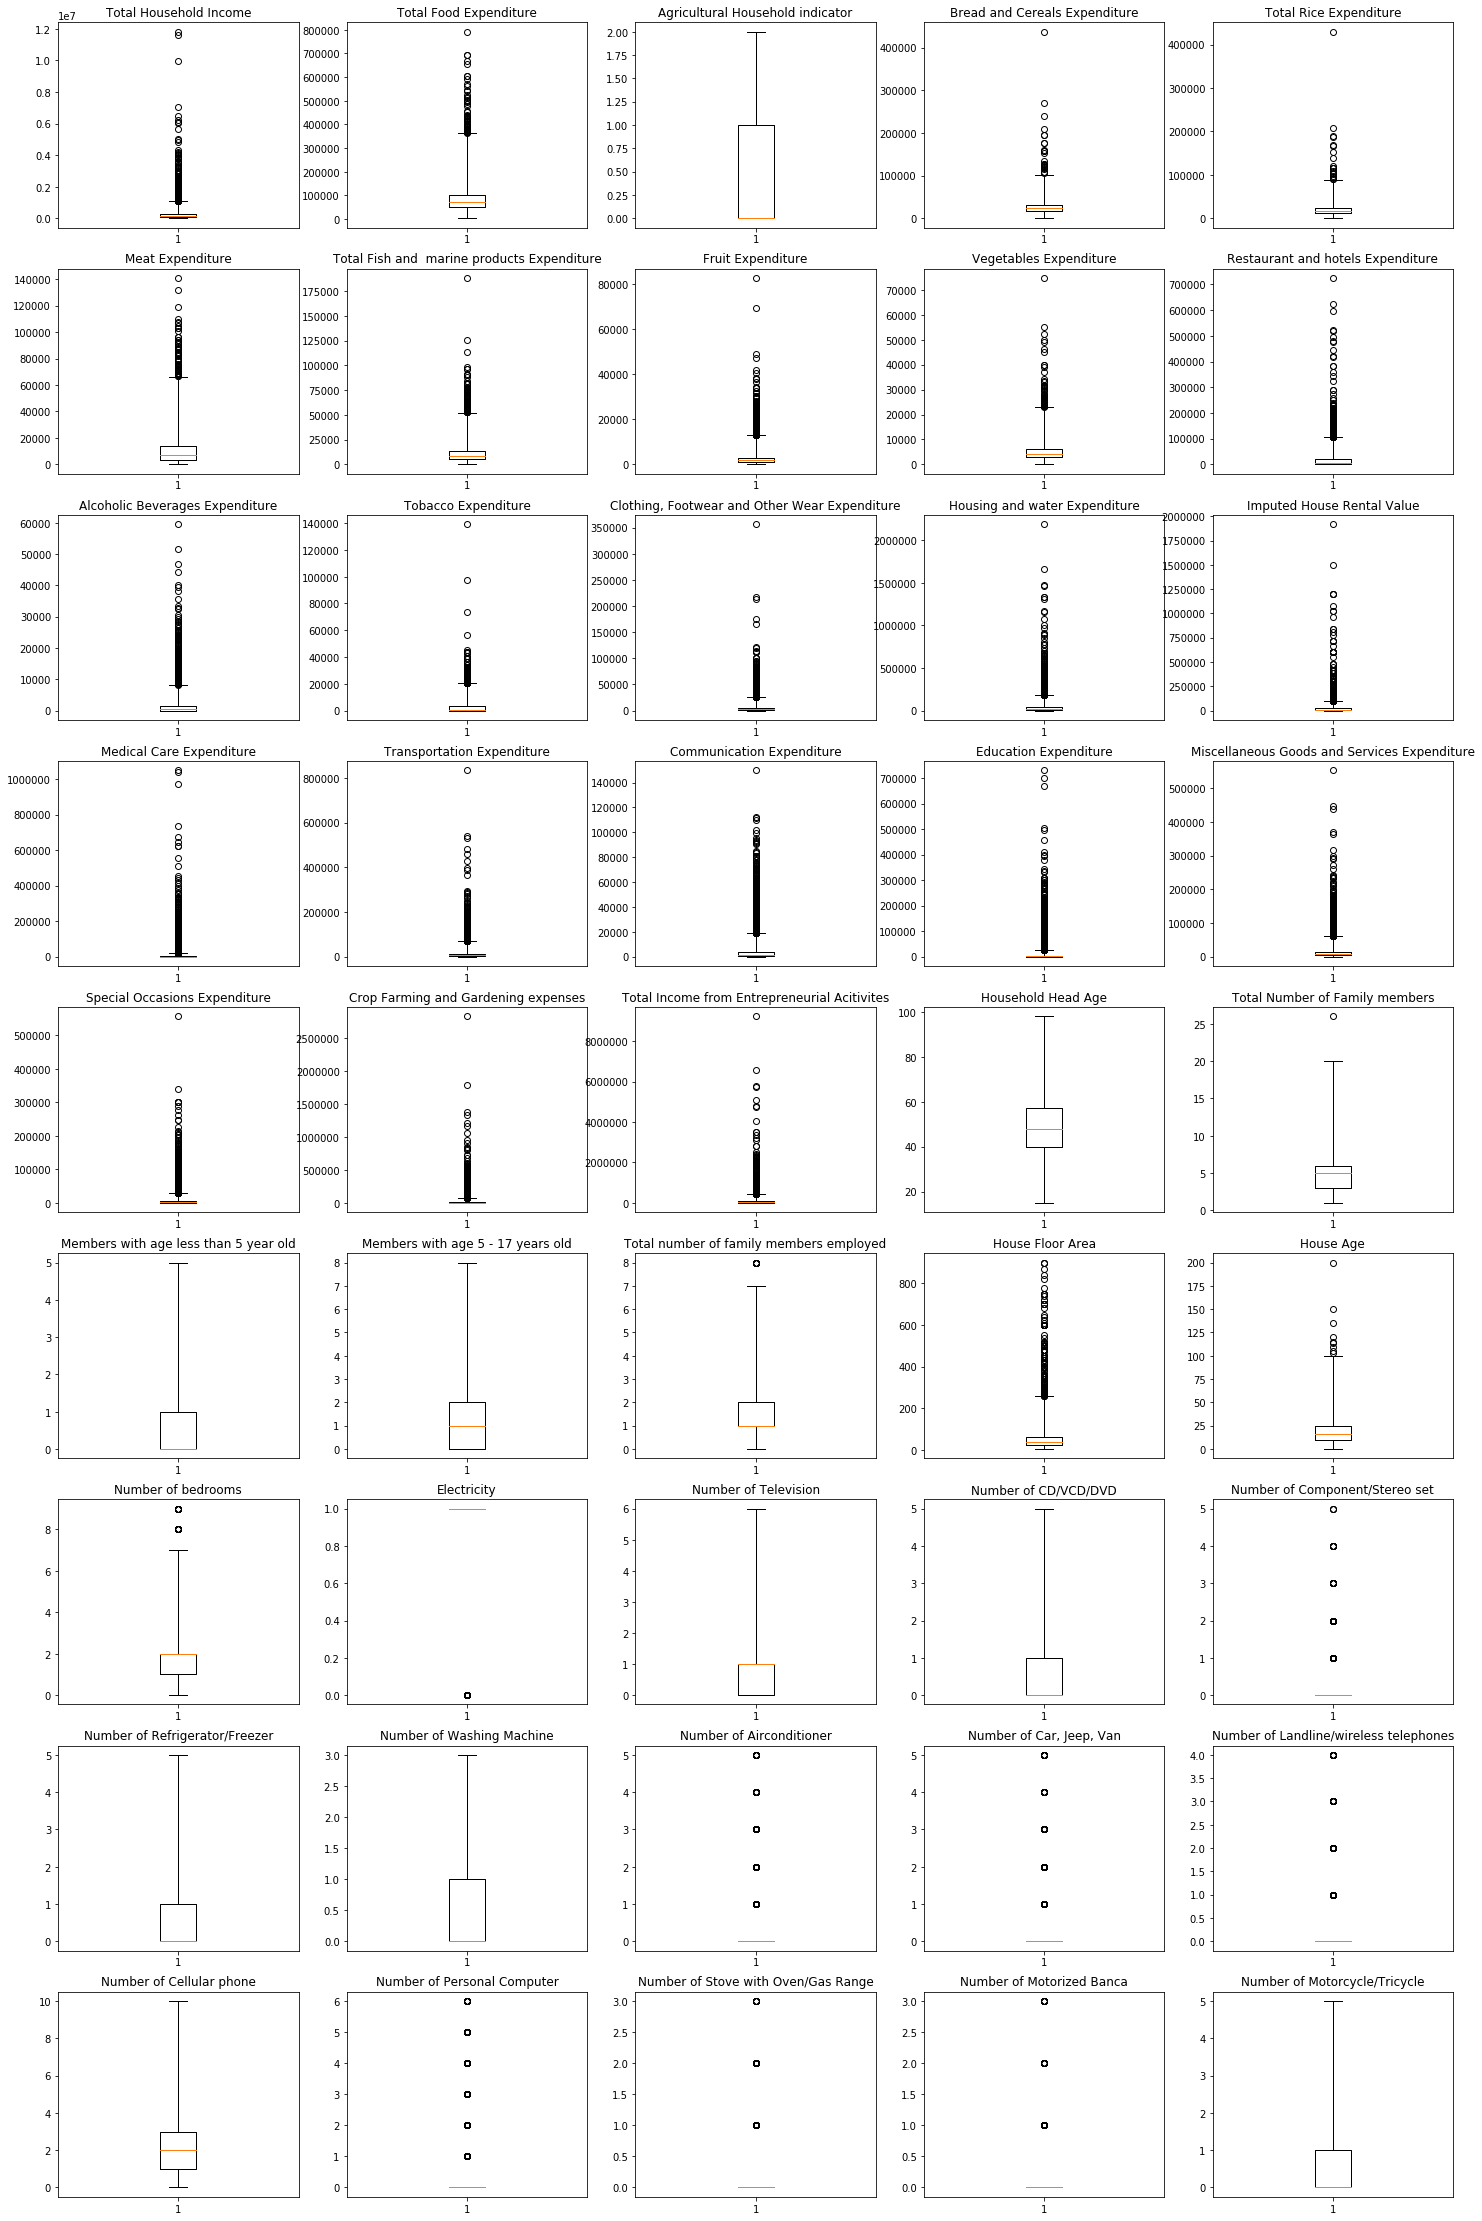

In [9]:
fig = plt.figure(figsize=(25,40))

plt.subplot(9, 5, 1)
plt.boxplot(df[numerical_columns[0]], whis=5)
plt.title(numerical_columns[0])

plt.subplot(9, 5, 2)
plt.boxplot(df[numerical_columns[1]], whis=5)
plt.title(numerical_columns[1])

plt.subplot(9, 5, 3)
plt.boxplot(df[numerical_columns[2]], whis=5)
plt.title(numerical_columns[2])

plt.subplot(9, 5, 4)
plt.boxplot(df[numerical_columns[3]], whis=5)
plt.title(numerical_columns[3])

plt.subplot(9, 5, 5)
plt.boxplot(df[numerical_columns[4]], whis=5)
plt.title(numerical_columns[4])

plt.subplot(9, 5, 6)
plt.boxplot(df[numerical_columns[5]], whis=5)
plt.title(numerical_columns[5])

plt.subplot(9, 5, 7)
plt.boxplot(df[numerical_columns[6]], whis=5)
plt.title(numerical_columns[6])

plt.subplot(9, 5, 8)
plt.boxplot(df[numerical_columns[7]], whis=5)
plt.title(numerical_columns[7])

plt.subplot(9, 5, 9)
plt.boxplot(df[numerical_columns[8]], whis=5)
plt.title(numerical_columns[8])

plt.subplot(9, 5, 10)
plt.boxplot(df[numerical_columns[9]], whis=5)
plt.title(numerical_columns[9])

plt.subplot(9, 5, 11)
plt.boxplot(df[numerical_columns[10]], whis=5)
plt.title(numerical_columns[10])

plt.subplot(9, 5, 12)
plt.boxplot(df[numerical_columns[11]], whis=5)
plt.title(numerical_columns[11])

plt.subplot(9, 5, 13)
plt.boxplot(df[numerical_columns[12]], whis=5)
plt.title(numerical_columns[12])

plt.subplot(9, 5, 14)
plt.boxplot(df[numerical_columns[13]], whis=5)
plt.title(numerical_columns[13])

plt.subplot(9, 5, 15)
plt.boxplot(df[numerical_columns[14]], whis=5)
plt.title(numerical_columns[14])

plt.subplot(9, 5, 16)
plt.boxplot(df[numerical_columns[15]], whis=5)
plt.title(numerical_columns[15])

plt.subplot(9, 5, 17)
plt.boxplot(df[numerical_columns[16]], whis=5)
plt.title(numerical_columns[16])

plt.subplot(9, 5, 18)
plt.boxplot(df[numerical_columns[17]], whis=5)
plt.title(numerical_columns[17])

plt.subplot(9, 5, 19)
plt.boxplot(df[numerical_columns[18]], whis=5)
plt.title(numerical_columns[18])

plt.subplot(9, 5, 20)
plt.boxplot(df[numerical_columns[19]], whis=5)
plt.title(numerical_columns[19])

plt.subplot(9, 5, 21)
plt.boxplot(df[numerical_columns[20]], whis=5)
plt.title(numerical_columns[20])

plt.subplot(9, 5, 22)
plt.boxplot(df[numerical_columns[21]], whis=5)
plt.title(numerical_columns[21])

plt.subplot(9, 5, 23)
plt.boxplot(df[numerical_columns[22]], whis=5)
plt.title(numerical_columns[22])

plt.subplot(9, 5, 24)
plt.boxplot(df[numerical_columns[23]], whis=5)
plt.title(numerical_columns[23])

plt.subplot(9, 5, 25)
plt.boxplot(df[numerical_columns[24]], whis=5)
plt.title(numerical_columns[24])

plt.subplot(9, 5, 26)
plt.boxplot(df[numerical_columns[25]], whis=5)
plt.title(numerical_columns[25])

plt.subplot(9, 5, 27)
plt.boxplot(df[numerical_columns[26]], whis=5)
plt.title(numerical_columns[26])

plt.subplot(9, 5, 28)
plt.boxplot(df[numerical_columns[27]], whis=5)
plt.title(numerical_columns[27])

plt.subplot(9, 5, 29)
plt.boxplot(df[numerical_columns[28]], whis=5)
plt.title(numerical_columns[28])

plt.subplot(9, 5, 30)
plt.boxplot(df[numerical_columns[29]], whis=5)
plt.title(numerical_columns[29])

plt.subplot(9, 5, 31)
plt.boxplot(df[numerical_columns[30]], whis=5)
plt.title(numerical_columns[30])

plt.subplot(9, 5, 32)
plt.boxplot(df[numerical_columns[31]], whis=5)
plt.title(numerical_columns[31])

plt.subplot(9, 5, 33)
plt.boxplot(df[numerical_columns[32]], whis=5)
plt.title(numerical_columns[32])

plt.subplot(9, 5, 34)
plt.boxplot(df[numerical_columns[33]], whis=5)
plt.title(numerical_columns[33])

plt.subplot(9, 5, 35)
plt.boxplot(df[numerical_columns[34]], whis=5)
plt.title(numerical_columns[34])

plt.subplot(9, 5, 36)
plt.boxplot(df[numerical_columns[35]], whis=5)
plt.title(numerical_columns[35])

plt.subplot(9, 5, 37)
plt.boxplot(df[numerical_columns[36]], whis=5)
plt.title(numerical_columns[36])

plt.subplot(9, 5, 38)
plt.boxplot(df[numerical_columns[37]], whis=5)
plt.title(numerical_columns[37])

plt.subplot(9, 5, 39)
plt.boxplot(df[numerical_columns[38]], whis=5)
plt.title(numerical_columns[38])

plt.subplot(9, 5, 40)
plt.boxplot(df[numerical_columns[39]], whis=5)
plt.title(numerical_columns[39])

plt.subplot(9, 5, 41)
plt.boxplot(df[numerical_columns[40]], whis=5)
plt.title(numerical_columns[40])

plt.subplot(9, 5, 42)
plt.boxplot(df[numerical_columns[41]], whis=5)
plt.title(numerical_columns[41])

plt.subplot(9, 5, 43)
plt.boxplot(df[numerical_columns[42]], whis=5)
plt.title(numerical_columns[42])

plt.subplot(9, 5, 44)
plt.boxplot(df[numerical_columns[43]], whis=5)
plt.title(numerical_columns[43])

plt.subplot(9, 5, 45)
plt.boxplot(df[numerical_columns[44]], whis=5)
plt.title(numerical_columns[44])

plt.show()

From the boxplots above, we can ignore outliers in many of the columns similar to "number of motorcycle" or "number of x". Therefore we will make a new list of columns of those we want to explore outliers further.

In [10]:
print(numerical_columns)
print(len(numerical_columns))

Index(['Total Household Income', 'Total Food Expenditure',
       'Agricultural Household indicator', 'Bread and Cereals Expenditure',
       'Total Rice Expenditure', 'Meat Expenditure',
       'Total Fish and  marine products Expenditure', 'Fruit Expenditure',
       'Vegetables Expenditure', 'Restaurant and hotels Expenditure',
       'Alcoholic Beverages Expenditure', 'Tobacco Expenditure',
       'Clothing, Footwear and Other Wear Expenditure',
       'Housing and water Expenditure', 'Imputed House Rental Value',
       'Medical Care Expenditure', 'Transportation Expenditure',
       'Communication Expenditure', 'Education Expenditure',
       'Miscellaneous Goods and Services Expenditure',
       'Special Occasions Expenditure', 'Crop Farming and Gardening expenses',
       'Total Income from Entrepreneurial Acitivites', 'Household Head Age',
       'Total Number of Family members',
       'Members with age less than 5 year old',
       'Members with age 5 - 17 years old',
      

In [11]:
outlier_columns = ['Total Household Income', 'Total Food Expenditure', 'Bread and Cereals Expenditure',
       'Total Rice Expenditure', 'Meat Expenditure',
       'Total Fish and  marine products Expenditure', 'Fruit Expenditure',
       'Vegetables Expenditure', 'Restaurant and hotels Expenditure',
       'Alcoholic Beverages Expenditure', 'Tobacco Expenditure',
       'Clothing, Footwear and Other Wear Expenditure',
       'Housing and water Expenditure', 'Imputed House Rental Value',
       'Medical Care Expenditure', 'Transportation Expenditure',
       'Communication Expenditure', 'Education Expenditure',
       'Miscellaneous Goods and Services Expenditure',
       'Special Occasions Expenditure', 'Crop Farming and Gardening expenses',
       'Total Income from Entrepreneurial Acitivites']
print (len(outlier_columns))

22


In [12]:
# Find out the number of outliers using a threshold value between 1 and 5
for column in outlier_columns:

    q75, q25 = np.percentile(df[column], [75 ,25])
    iqr = q75 - q25
    print("\n" + column)
    for threshold in np.arange(1,5,0.5):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
        #print(column)
        print("The score threshold is: {}".format(threshold))
        print("Number of outliers is: {}".format(len((np.where((df[column] > max_val) | (df[column] < min_val))[0]))))


Total Household Income
The score threshold is: 1.0
Number of outliers is: 3858
The score threshold is: 1.5
Number of outliers is: 2738
The score threshold is: 2.0
Number of outliers is: 1996
The score threshold is: 2.5
Number of outliers is: 1506
The score threshold is: 3.0
Number of outliers is: 1135
The score threshold is: 3.5
Number of outliers is: 885
The score threshold is: 4.0
Number of outliers is: 704
The score threshold is: 4.5
Number of outliers is: 571

Total Food Expenditure
The score threshold is: 1.0
Number of outliers is: 2674
The score threshold is: 1.5
Number of outliers is: 1559
The score threshold is: 2.0
Number of outliers is: 911
The score threshold is: 2.5
Number of outliers is: 556
The score threshold is: 3.0
Number of outliers is: 331
The score threshold is: 3.5
Number of outliers is: 213
The score threshold is: 4.0
Number of outliers is: 136
The score threshold is: 4.5
Number of outliers is: 84

Bread and Cereals Expenditure
The score threshold is: 1.0
Number 

Number of outliers is: 3857
The score threshold is: 3.5
Number of outliers is: 3451
The score threshold is: 4.0
Number of outliers is: 3073
The score threshold is: 4.5
Number of outliers is: 2720

Total Income from Entrepreneurial Acitivites
The score threshold is: 1.0
Number of outliers is: 2909
The score threshold is: 1.5
Number of outliers is: 2004
The score threshold is: 2.0
Number of outliers is: 1474
The score threshold is: 2.5
Number of outliers is: 1152
The score threshold is: 3.0
Number of outliers is: 936
The score threshold is: 3.5
Number of outliers is: 766
The score threshold is: 4.0
Number of outliers is: 629
The score threshold is: 4.5
Number of outliers is: 542


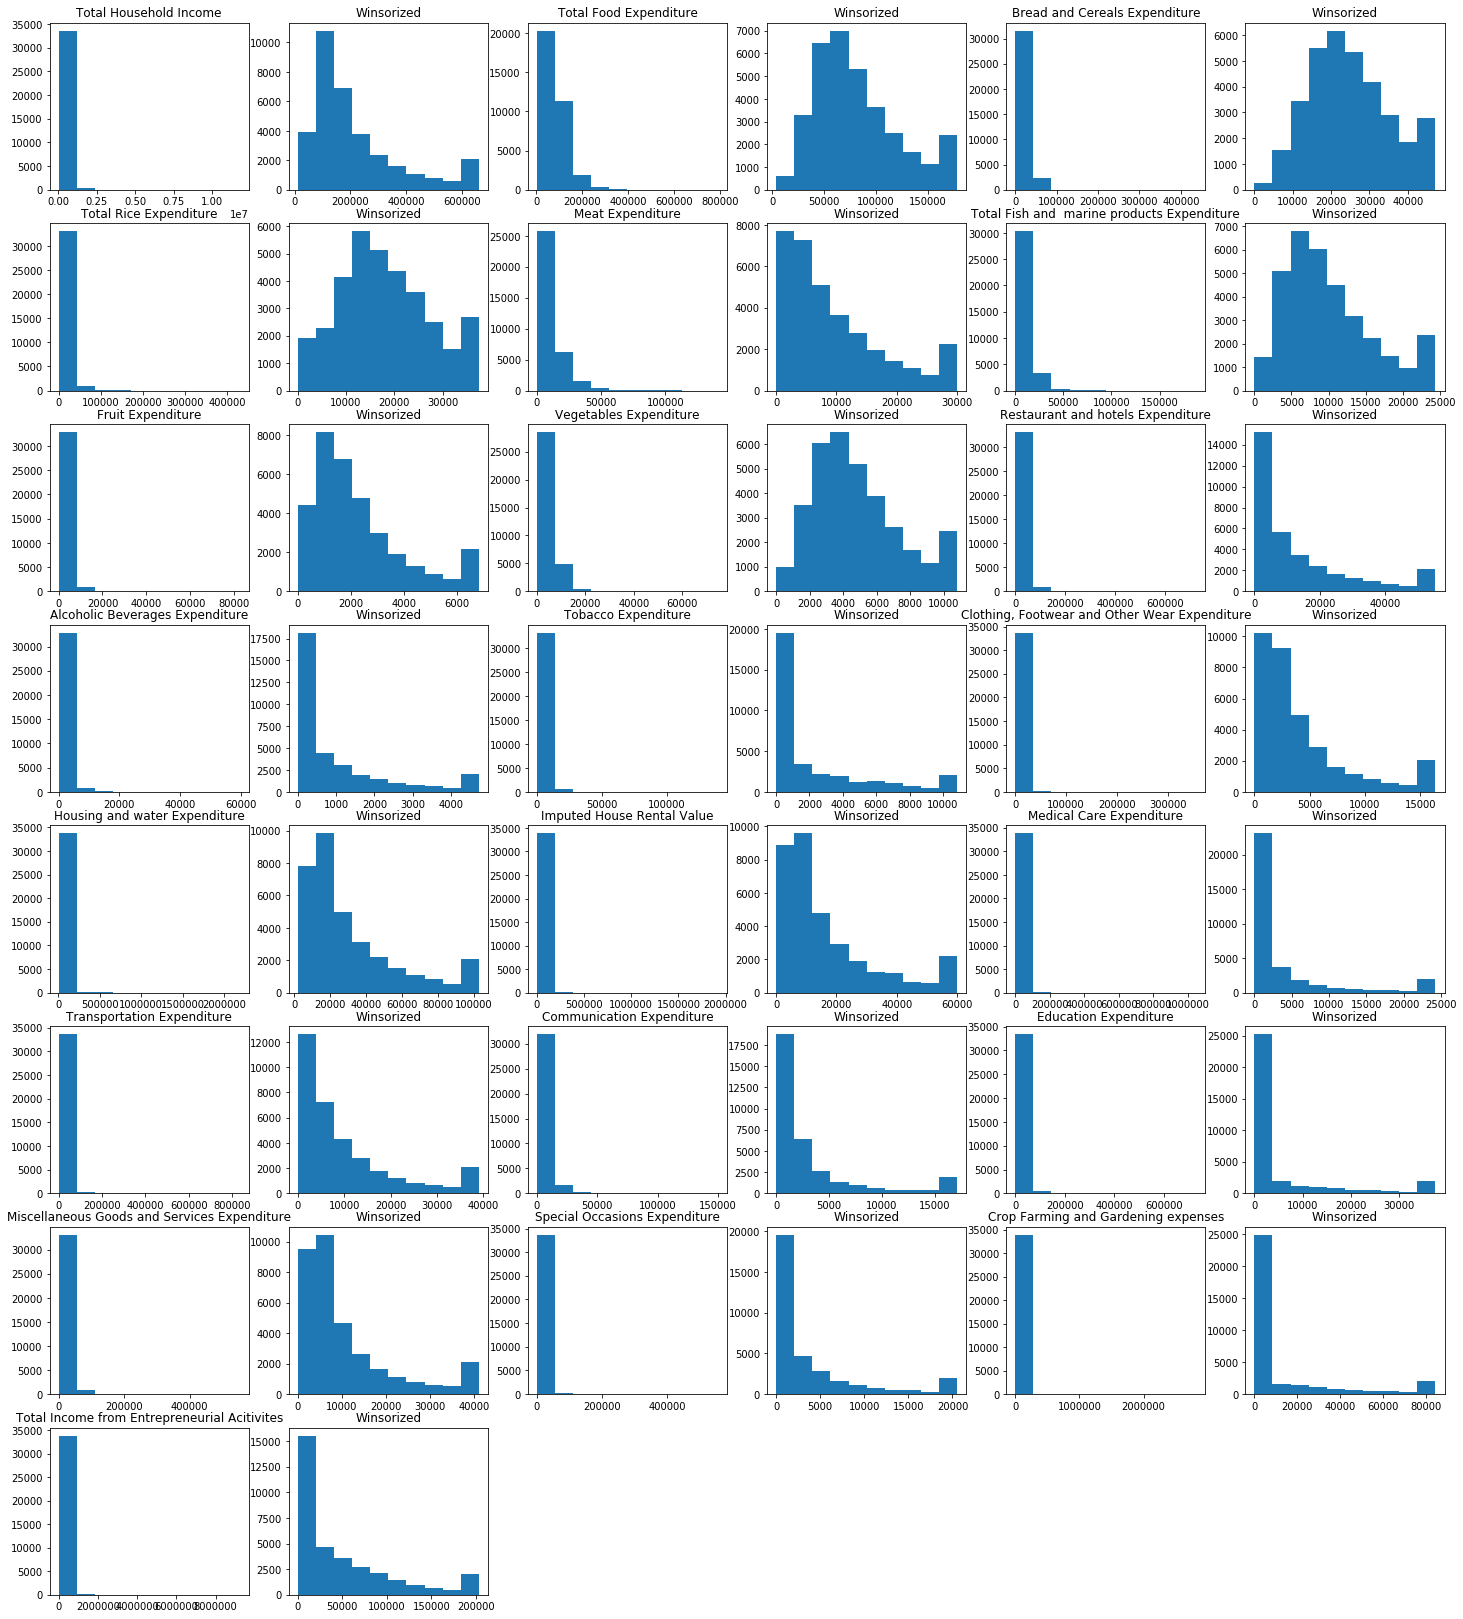

In [13]:
# Let's print histograms of each numerical column to visualize
fig = plt.figure(figsize=(25,40))
fig_count = 1
col_count = 0

for i in outlier_columns:
    plt.subplot(11, 6, fig_count)
    plt.hist(df[outlier_columns[col_count]])
    plt.title(outlier_columns[col_count])
    
    plt.subplot(11, 6, fig_count+1)
    plt.hist(winsorize(df[outlier_columns[col_count]], (0, 0.05)))
    plt.title("Winsorized")
    
    #plt.subplot(11, 6, fig_count+2)    
    #plt.hist(np.log(df[outlier_columns[col_count]]))
    #plt.title("Log Transformed:")
    
    #plt.subplot(11, 6, fig_count+2)
    #plt.hist(boxcox(abs(df[outlier_columns[col_count]])))
    #plt.title("Boxcox")
    
    fig_count += 2
    col_count += 1
    
plt.show()

# Feature Selection

Since it can be time-consuming to use every feature, we will determine which are the most important features to move forward with in our analysis.

In [14]:
# Make a new data frame that converts categorical columns into new dummies columns
dummies_df = pd.get_dummies(df)
dummies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34007 entries, 0 to 41542
Columns: 175 entries, Total Household Income to Main Source of Water Supply_Unprotected spring, river, stream, etc
dtypes: int64(45), uint8(130)
memory usage: 16.2 MB


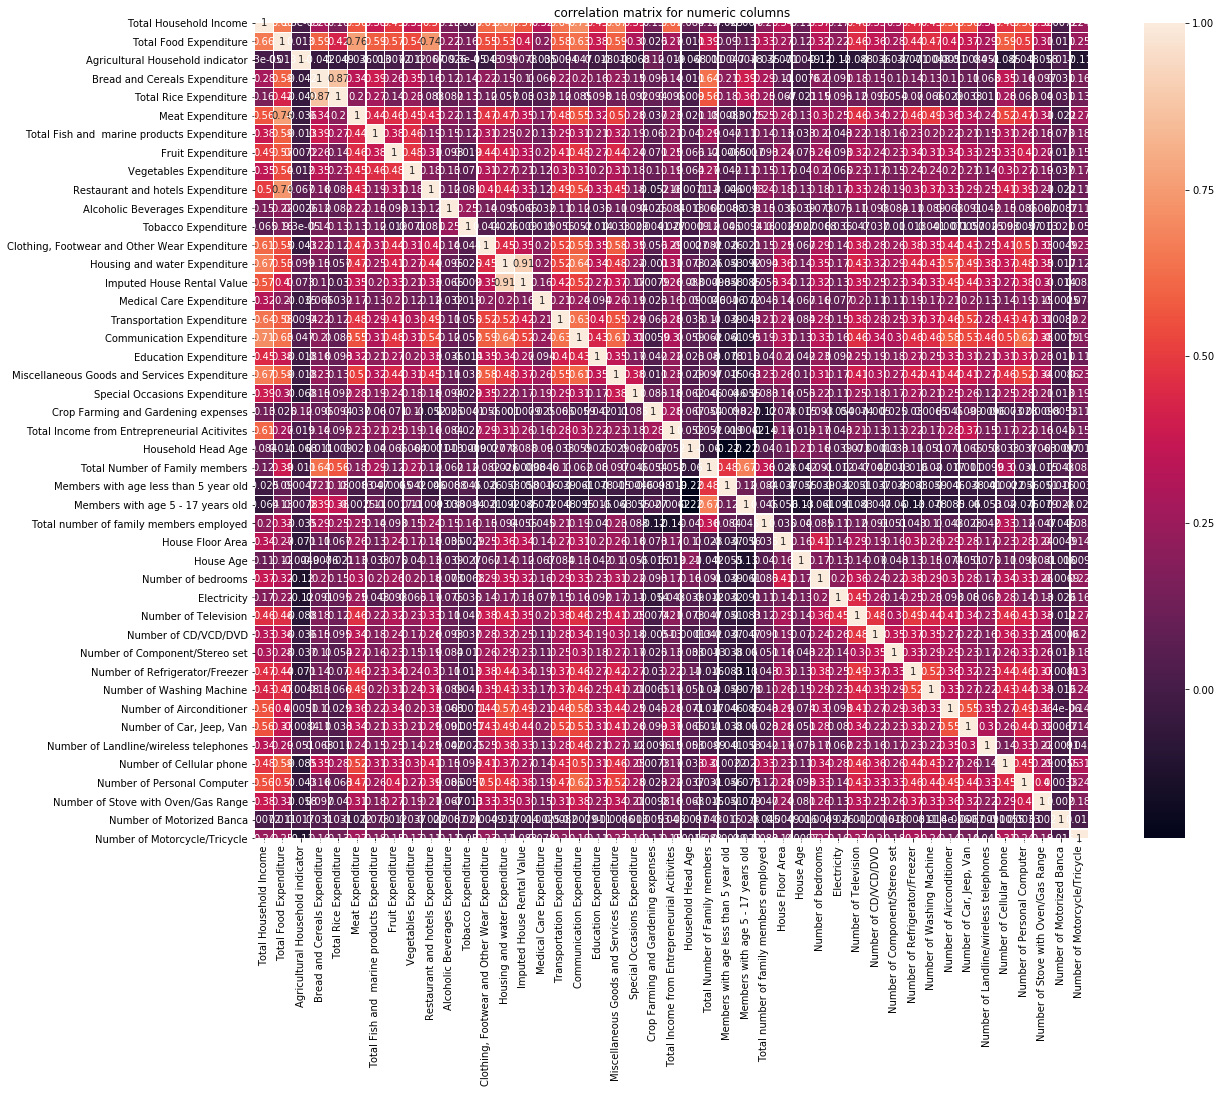

In [15]:
# Visualize heatmap of numerical values (using original dataframe as the get_dummies dataframe hasa 175 columns)
# This is just a visualization
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), square=True, annot=True, linewidths=.25)
plt.title("correlation matrix for numeric columns")
plt.show()

In [16]:
# We can also look at the raw values for correlations between all values in the dummies data frame
dummies_df.corr().round(3)

,Total Household Income,Total Food Expenditure,Agricultural Household indicator,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,...,"Main Source of Water Supply_Lake, river, rain and others",Main Source of Water Supply_Others,"Main Source of Water Supply_Own use, faucet, community water system","Main Source of Water Supply_Own use, tubed/piped deep well",Main Source of Water Supply_Peddler,"Main Source of Water Supply_Protected spring, river, stream, etc","Main Source of Water Supply_Shared, faucet, community water system","Main Source of Water Supply_Shared, tubed/piped deep well",Main Source of Water Supply_Tubed/piped shallow well,"Main Source of Water Supply_Unprotected spring, river, stream, etc"
Total Household Income,1.000,0.657,0.000,0.279,0.161,0.561,0.383,0.489,0.354,0.499,...,-0.045,-0.002,0.313,0.019,-0.024,-0.084,-0.088,-0.131,-0.038,-0.057
Total Food Expenditure,0.657,1.000,0.013,0.593,0.423,0.765,0.588,0.568,0.538,0.739,...,-0.047,-0.001,0.346,0.006,0.006,-0.123,-0.085,-0.129,-0.048,-0.076
Agricultural Household indicator,0.000,0.013,1.000,-0.042,-0.049,-0.036,-0.013,0.007,0.012,0.067,...,0.023,-0.001,0.000,-0.075,0.041,0.026,0.019,-0.034,-0.022,0.044
Bread and Cereals Expenditure,0.279,0.593,-0.042,1.000,0.866,0.339,0.389,0.260,0.348,0.165,...,0.002,0.005,0.075,0.014,-0.003,-0.021,-0.033,-0.028,-0.016,-0.023
Total Rice Expenditure,0.161,0.423,-0.049,0.866,1.000,0.205,0.272,0.136,0.229,0.083,...,0.017,0.010,0.008,0.046,0.000,-0.026,-0.034,0.010,0.002,-0.033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Main Source of Water Supply_Protected spring, river, stream, etc",-0.084,-0.123,0.026,-0.021,-0.026,-0.110,-0.080,-0.045,-0.022,-0.103,...,-0.032,-0.015,-0.205,-0.095,-0.040,1.000,-0.100,-0.119,-0.052,-0.035
"Main Source of Water Supply_Shared, faucet, community water system",-0.088,-0.085,0.019,-0.033,-0.034,-0.092,-0.067,-0.079,-0.081,-0.050,...,-0.042,-0.020,-0.272,-0.126,-0.053,-0.100,1.000,-0.157,-0.069,-0.046
"Main Source of Water Supply_Shared, tubed/piped deep well",-0.131,-0.129,-0.034,-0.028,0.010,-0.114,-0.073,-0.113,-0.058,-0.104,...,-0.050,-0.024,-0.324,-0.150,-0.064,-0.119,-0.157,1.000,-0.082,-0.055
Main Source of Water Supply_Tubed/piped shallow well,-0.038,-0.048,-0.022,-0.016,0.002,-0.028,-0.033,-0.038,-0.013,-0.044,...,-0.022,-0.010,-0.141,-0.066,-0.028,-0.052,-0.069,-0.082,1.000,-0.024


In [17]:
# Make a new dataframe that contains only correlation values relative to 'Total Household Income'
df_corr = pd.DataFrame(dummies_df.corr())
df_corr = df_corr.sort_values(by='Total Household Income', ascending=False)

# Create new column that takes the absolute value of these correlations, then sorts by descending
df_corr['abs'] = abs(df_corr['Total Household Income'])
df_corr = df_corr[['Total Household Income', 'abs']]
df_corr = df_corr.sort_values(by='abs', ascending=False)

# Below is the 20 columns that havae the most correlation with 'Total Household Income'
df_corr.head(21)

,Total Household Income,abs
Total Household Income,1.000000,1.000000
Communication Expenditure,0.711835,0.711835
Housing and water Expenditure,0.671537,0.671537
Miscellaneous Goods and Services Expenditure,0.666605,0.666605
Total Food Expenditure,0.657478,0.657478
Transportation Expenditure,0.644419,0.644419
"Clothing, Footwear and Other Wear Expenditure",0.614648,0.614648
Total Income from Entrepreneurial Acitivites,0.612427,0.612427
Imputed House Rental Value,0.570734,0.570734
Number of Airconditioner,0.563486,0.563486


In [18]:
# These will be the 20 columns from which we will base our models
# First I'll create a list of column names (I've taken out the first column as its our target variable)
feature_list = [x for x in df_corr.head(21)[1:].index]
feature_list

['Communication Expenditure',
 'Housing and water Expenditure',
 'Miscellaneous Goods and Services Expenditure',
 'Total Food Expenditure',
 'Transportation Expenditure',
 'Clothing, Footwear and Other Wear Expenditure',
 'Total Income from Entrepreneurial Acitivites',
 'Imputed House Rental Value',
 'Number of Airconditioner',
 'Meat Expenditure',
 'Number of Car, Jeep, Van',
 'Number of Personal Computer',
 'Restaurant and hotels Expenditure',
 'Fruit Expenditure',
 'Number of Cellular phone',
 'Number of Refrigerator/Freezer',
 'Number of Television',
 'Education Expenditure',
 'Number of Washing Machine',
 'Special Occasions Expenditure']

# Supervised Learning

## Setting up Model

In [19]:
# Define our target variable
Y = df['Total Household Income']

# Define our feature variables
X = df[feature_list]

# Define our alpha range for Lasso/Ridge/ElasticNet
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [20]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 365)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 27205
The number of observations in test set is 6802


Now that we have split our data into train/test sets we can begin exploring supervised learning models below

## Logistic Regression Classifier (OLS)

In [21]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.8138122124025791
-----Test set statistics-----
R-squared of the model in test set is: 0.8541156586435326
Mean absolute error of the prediction is: 51924.706429613965
Mean squared error of the prediction is: 9304537092.10027
Root mean squared error of the prediction is: 96460.0284682742
Mean absolute percentage error of the prediction is: 23.305711394530316


## LassoCV

In [22]:
lassoregr = LassoCV(alphas=alphas, cv=5)
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("Best alpha value is: {}".format(lassoregr.alpha_))
print("R-squared of the model in training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97500911914811.19, tolerance: 186667678259.27228
  tol, rng, random, positive)
C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140466147468782.69, tolerance: 186667678259.27228
  tol, rng, random, positive)
C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 142446810680812.53, tolerance: 186667678259.27228
  tol, rng, random, positive)
C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

Best alpha value is: 100.0
R-squared of the model in training set is: 0.8138076987775513
-----Test set statistics-----
R-squared of the model in test set is: 0.8541808748620999
Mean absolute error of the prediction is: 51921.18663591035
Mean squared error of the prediction is: 9300377586.569904
Root mean squared error of the prediction is: 96438.46528522685
Mean absolute percentage error of the prediction is: 23.29255674986626


## RidgeCV

In [23]:
ridgeregr = RidgeCV(alphas=alphas, cv=5) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("Best alpha value is: {}".format(ridgeregr.alpha_))
print("R-squared of the model in training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1000.0
R-squared of the model in training set is: 0.8137257489065401
-----Test set statistics-----
R-squared of the model in test set is: 0.8543251845101473
Mean absolute error of the prediction is: 51914.76794850644
Mean squared error of the prediction is: 9291173483.781904
Root mean squared error of the prediction is: 96390.7333916591
Mean absolute percentage error of the prediction is: 23.304563537150386


## ElasticNetCV

In [24]:
elasticregr = ElasticNetCV(alphas=alphas, cv=5) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("Best alpha value is: {}".format(elasticregr.alpha_))
print("R-squared of the model in training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120472563676067.58, tolerance: 186667678259.27228
  tol, rng, random, positive)
C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141698574725961.84, tolerance: 186667678259.27228
  tol, rng, random, positive)
C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 142695523089568.72, tolerance: 186667678259.27228
  tol, rng, random, positive)
C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

Best alpha value is: 0.1
R-squared of the model in training set is: 0.813678093659407
-----Test set statistics-----
R-squared of the model in test set is: 0.8543409859177081
Mean absolute error of the prediction is: 51917.8236100602
Mean squared error of the prediction is: 9290165666.346598
Root mean squared error of the prediction is: 96385.50547850334
Mean absolute percentage error of the prediction is: 23.305020641802113


## KNN

In [25]:
neighbors = KNeighborsClassifier(n_neighbors=5)
neighbors.fit(X_train, y_train)

# We are making predictions here
y_preds_train = neighbors.predict(X_train)
y_preds_test = neighbors.predict(X_test)

print("R-squared of the model in training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.813678093659407
-----Test set statistics-----
R-squared of the model in test set is: 0.8543409859177081
Mean absolute error of the prediction is: 73346.5414583946
Mean squared error of the prediction is: 21642674756.784622
Root mean squared error of the prediction is: 147114.4953999592
Mean absolute percentage error of the prediction is: 26.575261238078795


## Decision Tree

In [29]:
# Needed to add this to get the graphviz to work


import os
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"


In [27]:
# Start time for this model
start_time = time.time()

# Initialize and train decision tree
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=5,
    random_state = 1337
)
decision_tree.fit(X_train, y_train)

# We are making predictions here
y_preds_train = decision_tree.predict(X_train)
y_preds_test = decision_tree.predict(X_test)

print("R-squared of the model in training set is: {}".format(decision_tree.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(decision_tree.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

print ("--- %s seconds ---" % (time.time() - start_time))

R-squared of the model in training set is: 0.0018011394964161
-----Test set statistics-----
R-squared of the model in test set is: 0.0
Mean absolute error of the prediction is: 125150.67671273155
Mean squared error of the prediction is: 60701116912.652016
Root mean squared error of the prediction is: 246375.9665889756
Mean absolute percentage error of the prediction is: 45.2298064040291
--- 18.686964511871338 seconds ---


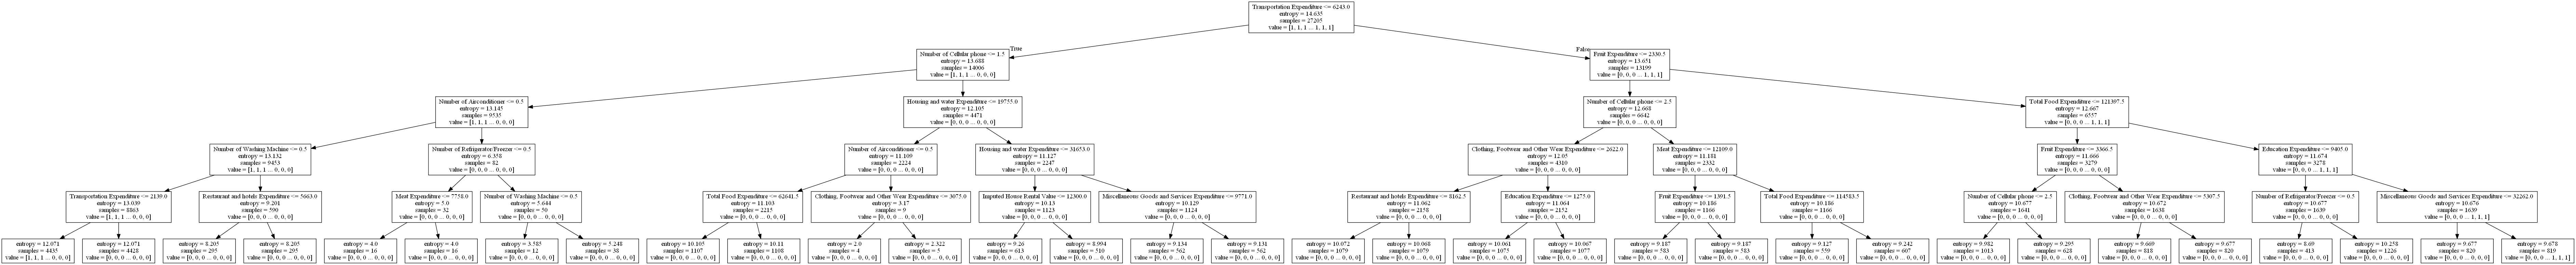

In [30]:
# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    #class_names=df['Total Household Income'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

As we can see from a single decision tree, the performance isn't great. We can compare this to a Random Forest model in the next section.

## Random Forest

In [33]:
# Start time for this model
start_time = time.time()

clf = ensemble.RandomForestClassifier(max_depth=4)
clf.fit(X_train, y_train)

# We are making predictions here
y_preds_train = clf.predict(X_train)
y_preds_test = clf.predict(X_test)

print("R-squared of the model in training set is: {}".format(clf.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(clf.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

print ("--- %s seconds ---" % (time.time() - start_time))

C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R-squared of the model in training set is: 0.002462782576732218
-----Test set statistics-----
R-squared of the model in test set is: 0.0
Mean absolute error of the prediction is: 140513.1922963834
Mean squared error of the prediction is: 67398194409.73479
Root mean squared error of the prediction is: 259611.62225473416
Mean absolute percentage error of the prediction is: 49.16822510359737
--- 200.18771147727966 seconds ---


In [36]:
# Trying RandomForestRegressor instead of classifier
# Start time for this model
start_time = time.time()

clf = ensemble.RandomForestRegressor()
clf.fit(X_train, y_train)

# We are making predictions here
y_preds_train = clf.predict(X_train)
y_preds_test = clf.predict(X_test)

print("R-squared of the model in training set is: {}".format(clf.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(clf.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

print ("--- %s seconds ---" % (time.time() - start_time))

C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R-squared of the model in training set is: 0.9576513906367157
-----Test set statistics-----
R-squared of the model in test set is: 0.836855611514922
Mean absolute error of the prediction is: 49039.77746251102
Mean squared error of the prediction is: 10405386896.99563
Root mean squared error of the prediction is: 102006.7982881319
Mean absolute percentage error of the prediction is: 21.570267261999813
--- 3.5366389751434326 seconds ---


In [37]:
# Let's try with the 'gini' criterion and different max depths

# Start time for this model
start_time = time.time()

clf = ensemble.RandomForestClassifier(criterion='gini',
    max_features='log2',
    max_depth=3,
    n_estimators=15)
clf.fit(X_train, y_train)

# We are making predictions here
y_preds_train = clf.predict(X_train)
y_preds_test = clf.predict(X_test)

print("R-squared of the model in training set is: {}".format(clf.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(clf.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

print ("--- %s seconds ---" % (time.time() - start_time))

R-squared of the model in training set is: 0.0025362984745451204
-----Test set statistics-----
R-squared of the model in test set is: 0.0
Mean absolute error of the prediction is: 131317.1187885916
Mean squared error of the prediction is: 71376733909.2949
Root mean squared error of the prediction is: 267164.24519253115
Mean absolute percentage error of the prediction is: 53.79363791781857
--- 284.0814814567566 seconds ---


## Support Vector Machine (SVM)

In [41]:
# Start time for this model
start_time = time.time()

svr = SVR()
svr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = svr.predict(X_train)
y_preds_test = svr.predict(X_test)

print("R-squared of the model in training set is: {}".format(svr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(svr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

print ("--- %s seconds ---" % (time.time() - start_time))

TypeError: __init__() got an unexpected keyword argument 'n_estimators'

In [43]:
# Start time for this model
start_time = time.time()

svr = LinearSVR()
svr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = svr.predict(X_train)
y_preds_test = svr.predict(X_test)

print("R-squared of the model in training set is: {}".format(svr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(svr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

print ("--- %s seconds ---" % (time.time() - start_time))

R-squared of the model in training set is: 0.5974077078430418
-----Test set statistics-----
R-squared of the model in test set is: 0.7066575466344257
Mean absolute error of the prediction is: 62509.6271881702
Mean squared error of the prediction is: 18709449641.057575
Root mean squared error of the prediction is: 136782.49025755297
Mean absolute percentage error of the prediction is: 25.00651529273127
--- 5.205231189727783 seconds ---


C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# Model Score
svr.score(X_test, y_test)

## Gradient Boosting

In [ ]:
# Start time for this model
start_time = time.time()

params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

# We are making predictions here
y_preds_train = clf.predict(X_train)
y_preds_test = clf.predict(X_test)

print("R-squared of the model in training set is: {}".format(clf.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(clf.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

print ("--- %s seconds ---" % (time.time() - start_time))

In [39]:
# Start time for this model
start_time = time.time()

clf = ensemble.GradientBoostingRegressor()
clf.fit(X_train, y_train)

# We are making predictions here
y_preds_train = clf.predict(X_train)
y_preds_test = clf.predict(X_test)

print("R-squared of the model in training set is: {}".format(clf.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(clf.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

print ("--- %s seconds ---" % (time.time() - start_time))

R-squared of the model in training set is: 0.9168570240094019
-----Test set statistics-----
R-squared of the model in test set is: 0.8123190453412938
Mean absolute error of the prediction is: 47884.66351708657
Mean squared error of the prediction is: 11970334772.500948
Root mean squared error of the prediction is: 109409.02509620012
Mean absolute percentage error of the prediction is: 22.00116713830243
--- 2.5715384483337402 seconds ---


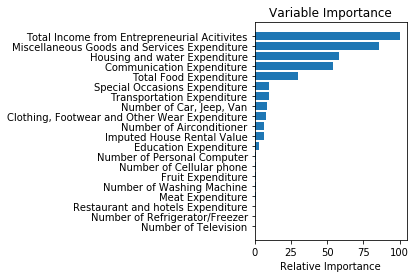

In [40]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()